# IS843 Team Assignment

### Team member: Frank Huang,  Lingyi Xu, Ryan Hayes

### Here's the content of this notebook:
    1. Data overview
    2. Data loading and cleaning
    3. Exploratory data analysis
        3.1 Basic summary
            3.1.1 Top Names that are adopted for Cats and Dogs
            3.1.2 Top Animal Dog names which were adopted
            3.1.3 Top 10 female Dog colors which were adopted
            3.1.4 Top 10 male Dog colors which were adopted
            3.1.5 Which are the most desireable female Dogs adopted with potential mating ability?
            3.1.6 Animals with high need for foster care
            3.1.7 Distinct number of breeds that entered the shelter
            3.1.8 Percentage of adoptions that are foster adoptions
        3.2 Data visualization
            3.2.1 Age distribution
            3.2.2 Amount of acitivity records in Astin Animal Shelter by month
            3.2.3 Sex
            3.2.4 Color
            3.2.5 Fertility
            3.2.6 Outcome
            3.2.7 Number of times an animal was sent to the shelter
    

## 1. Data overview

Data Overview - Raw Data
This is a historical dataset on animal shelter statistics. It has a running list of a variety of animal types. We want to focus on dogs or cats, which can be segregated by a unique animal id. Our team would like to analyze the trends between adoption and the traits given in the spreadsheet.

Does one breed rule over the others? Is there a certain color(s) that attract adopters? Is age a factor in adoption rates? Do adopters need an animal that has gone through a reproductive organ procedure?

These are just a few of the questions we hope to address in our code catalog, that we hope you enjoy processing along with us!

The source of the data was derived from Kaggle. Background on the dataset: https://www.kaggle.com/wenlie/exploring-and-predicting-the-animal-s-outcomes The data was https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-outcomes-and#aac_shelter_outcomes.csv

Attributes: aac_shelter_outcomes_cleaned_V4.csv

|Column Name|Data Type|Description
|--|--|--|
|age_upon_outcome|String|Age of the Animal in Weeks, Months, Years|
|animal_id|integer|Unique number for each animal|
|animal_type|string|Dog, Cat, Livestock, Bird, or Other|
|breed|string|Breed of the Animal|
|color|string|Color(s) on Animal|
|date_of_birth|string|Birth Date of Animal|
|datetime|string|Date of Entry into Shelter|
|monthyear|string|Date of Entry into Shelter|
|name|string|Name of Animal|
|outcome_subtype|string|Specific Outcome related to the outcome_type (snr = Shelter Neuter Return, scrp = Stray Cat Return Program|
|outcome_type|string|Outcome of the Pet after Visiting the Shelter|
|sex_upon_outcome|string|Reproductive Status and Gender|

There will be several steps taken to cleanup the data:

|Problem Number|Column Name Impacted|Add,Edit,Drop|Reason for Change
|--|--|--|--|
|1.|age_upon_outcome|Drop Column|Inconsistency data values (weeks, months, and years interchanged)|
|2.|breed|Drop Unknown Results|Cannot draw insights from unknown breeds|
|3.|sex_upon_outcome|Drop Unknown Sex Results|Cannot draw insight from unknown Sex|
|4.|sex_upon_outcome|Edit Split|Contains 2 desired values: sex and reproduction status|
|5.|sex_upon_outcome|Drop Column|Split the column into two new columns; no longer have a need for this column|
|6.|breed|Edit Word|Removed the word "Mix" from the values|
|7.|breed|Add New Column|Add a Color Number column to better distinguish animal breeds|
|8.|datetime|Drop Column|Duplicate of the monthyear column, which we consider more accurate|


## 2. Data loading and cleaning

In [1]:
data = "gs://killthehw/notebooks/"

In [2]:
shelter_original = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(data + "aac_shelter_outcomes.csv")

In [3]:
shelter_original.show(5, False)
shelter_original.printSchema()

+----------------+---------+-----------+-----------------------+------------+-------------------+-------------------+-------------------+-------+---------------+------------+----------------+
|age_upon_outcome|animal_id|animal_type|breed                  |color       |date_of_birth      |datetime           |monthyear          |name   |outcome_subtype|outcome_type|sex_upon_outcome|
+----------------+---------+-----------+-----------------------+------------+-------------------+-------------------+-------------------+-------+---------------+------------+----------------+
|2 weeks         |A684346  |Cat        |Domestic Shorthair Mix |Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|2014-07-22 16:04:00|null   |Partner        |Transfer    |Intact Male     |
|1 year          |A666430  |Dog        |Beagle Mix             |White/Brown |2012-11-06 00:00:00|2013-11-07 11:47:00|2013-11-07 11:47:00|Lucy   |Partner        |Transfer    |Spayed Female   |
|1 year          |A675708  |Dog        |

We only keep dogs and cats in our research.

In [4]:
from pyspark.sql.functions import col
dog_cat_shelterdata = shelter_original.where((col("animal_type")=="Dog")|(col("animal_type")=="Cat"))

In [5]:
dog_cat_shelterdata.show(5)

+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------------------+-------+---------------+------------+----------------+
|age_upon_outcome|animal_id|animal_type|               breed|       color|      date_of_birth|           datetime|          monthyear|   name|outcome_subtype|outcome_type|sex_upon_outcome|
+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------------------+-------+---------------+------------+----------------+
|         2 weeks|  A684346|        Cat|Domestic Shorthai...|Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|2014-07-22 16:04:00|   null|        Partner|    Transfer|     Intact Male|
|          1 year|  A666430|        Dog|          Beagle Mix| White/Brown|2012-11-06 00:00:00|2013-11-07 11:47:00|2013-11-07 11:47:00|   Lucy|        Partner|    Transfer|   Spayed Female|
|          1 year|  A675708|        Dog|            Pit

In [6]:
# manually calculate animal age and drop column "age_upon_outcome", because the given data is not precise

from pyspark.sql.functions import datediff, to_date, lit
dog_cat_shelterdata = dog_cat_shelterdata.withColumn("age_upon_outcome", datediff(to_date("monthyear","yyyy-MM-dd'T'HH:mm:ss"),to_date("date_of_birth","yyyy-MM-dd'T'HH:mm:ss")))
dog_cat_shelterdata.show(5)

+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------------------+-------+---------------+------------+----------------+
|age_upon_outcome|animal_id|animal_type|               breed|       color|      date_of_birth|           datetime|          monthyear|   name|outcome_subtype|outcome_type|sex_upon_outcome|
+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------------------+-------+---------------+------------+----------------+
|              15|  A684346|        Cat|Domestic Shorthai...|Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|2014-07-22 16:04:00|   null|        Partner|    Transfer|     Intact Male|
|             366|  A666430|        Dog|          Beagle Mix| White/Brown|2012-11-06 00:00:00|2013-11-07 11:47:00|2013-11-07 11:47:00|   Lucy|        Partner|    Transfer|   Spayed Female|
|             429|  A675708|        Dog|            Pit

In [7]:
# drop column "datetime", which is duplicate of column "monthyear"

dog_cat_shelterdata = dog_cat_shelterdata.drop("datetime")
dog_cat_shelterdata.columns

['age_upon_outcome',
 'animal_id',
 'animal_type',
 'breed',
 'color',
 'date_of_birth',
 'monthyear',
 'name',
 'outcome_subtype',
 'outcome_type',
 'sex_upon_outcome']

In [8]:
# drop records where breed is unknown

dog_cat_shelterdata = dog_cat_shelterdata.where(col("breed")!="Unknown Mix")
print("The number of records now is {}.".format(dog_cat_shelterdata.count()))

The number of records now is 73663.


In [9]:
# drop records where outcome type is unknown

dog_cat_shelterdata = dog_cat_shelterdata.where((col("outcome_type")!="Unknown")&(col("outcome_type")!=""))
dog_cat_shelterdata = dog_cat_shelterdata.na.drop("all", subset=["outcome_type"])
print("The number of records now is {}.".format(dog_cat_shelterdata.count()))

The number of records now is 73656.


In [10]:
# drop records where sex_upon_outcome is unknown

dog_cat_shelterdata = dog_cat_shelterdata.where((col("sex_upon_outcome")!="Unknown")&(col("sex_upon_outcome")!=""))
dog_cat_shelterdata = dog_cat_shelterdata.na.drop("all", subset=["sex_upon_outcome"])
print("The number of records now is {}.".format(dog_cat_shelterdata.count()))

The number of records now is 70892.


In [11]:
# drop records where the arrival time is before date of birth

dog_cat_shelterdata = dog_cat_shelterdata.where(col("date_of_birth")<=col("monthyear"))
print("The number of records now is {}.".format(dog_cat_shelterdata.count()))

The number of records now is 70885.


In [12]:
# split the sex_upon_outcome column into two new columns: "reproduction" and "sex"

from pyspark.sql.functions import split
split_col = split(dog_cat_shelterdata["sex_upon_outcome"], " ")
dog_cat_shelterdata = dog_cat_shelterdata.withColumn('reproduction', split_col.getItem(0))
dog_cat_shelterdata = dog_cat_shelterdata.withColumn('sex', split_col.getItem(1))
dog_cat_shelterdata.drop(col("sex_upon_outcome"))
dog_cat_shelterdata.show(5)

+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------+---------------+------------+----------------+------------+------+
|age_upon_outcome|animal_id|animal_type|               breed|       color|      date_of_birth|          monthyear|   name|outcome_subtype|outcome_type|sex_upon_outcome|reproduction|   sex|
+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------+---------------+------------+----------------+------------+------+
|              15|  A684346|        Cat|Domestic Shorthai...|Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|   null|        Partner|    Transfer|     Intact Male|      Intact|  Male|
|             366|  A666430|        Dog|          Beagle Mix| White/Brown|2012-11-06 00:00:00|2013-11-07 11:47:00|   Lucy|        Partner|    Transfer|   Spayed Female|      Spayed|Female|
|             429|  A675708|        Dog|            Pit

In [13]:
# drop records where sex is null

dog_cat_shelterdata = dog_cat_shelterdata.where(col("sex")!="NULL")
print("The number of records now is {}.".format(dog_cat_shelterdata.count()))

The number of records now is 70884.


In [14]:
# delete "mix" in breed variable for further operation, because we do not take inter-breed mix into consideration

from pyspark.sql.functions import *
# dog_cat_no_mix = dog_cat_shelterdata.withColumn("breed", regexp_replace(col("breed"), "\\ Mix", ""))
dog_cat_no_mix = dog_cat_shelterdata.withColumn("breed", regexp_replace("breed", " Mix", ""))
dog_cat_no_mix.show(5)

+----------------+---------+-----------+-------------------+------------+-------------------+-------------------+-------+---------------+------------+----------------+------------+------+
|age_upon_outcome|animal_id|animal_type|              breed|       color|      date_of_birth|          monthyear|   name|outcome_subtype|outcome_type|sex_upon_outcome|reproduction|   sex|
+----------------+---------+-----------+-------------------+------------+-------------------+-------------------+-------+---------------+------------+----------------+------------+------+
|              15|  A684346|        Cat| Domestic Shorthair|Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|   null|        Partner|    Transfer|     Intact Male|      Intact|  Male|
|             366|  A666430|        Dog|             Beagle| White/Brown|2012-11-06 00:00:00|2013-11-07 11:47:00|   Lucy|        Partner|    Transfer|   Spayed Female|      Spayed|Female|
|             429|  A675708|        Dog|           Pit Bull|

In [15]:
# calculate the number of colors according to number of "/" in color variable. Be aware of "Tricolor"!

dog_cat_shelterdata = dog_cat_shelterdata.withColumn("color_new", regexp_replace("color", "Tricolor", "//"))
dog_cat_shelterdata = dog_cat_shelterdata.withColumn("color_num", length(regexp_replace("color_new", '[a-zA-Z\s]', ""))+1).drop(col("color_new"))
dog_cat_shelterdata.show(5)

+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------+---------------+------------+----------------+------------+------+---------+
|age_upon_outcome|animal_id|animal_type|               breed|       color|      date_of_birth|          monthyear|   name|outcome_subtype|outcome_type|sex_upon_outcome|reproduction|   sex|color_num|
+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+-------+---------------+------------+----------------+------------+------+---------+
|              15|  A684346|        Cat|Domestic Shorthai...|Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|   null|        Partner|    Transfer|     Intact Male|      Intact|  Male|        1|
|             366|  A666430|        Dog|          Beagle Mix| White/Brown|2012-11-06 00:00:00|2013-11-07 11:47:00|   Lucy|        Partner|    Transfer|   Spayed Female|      Spayed|Female|        2|
|    

In [16]:
# create a column "is_sc" to see if the animal has single color

dog_cat_shelterdata = dog_cat_shelterdata.withColumn("is_sc", when(dog_cat_shelterdata["color_num"]==1, 1).otherwise(0))

In [17]:
# delete "*" in names

dog_cat_shelterdata = dog_cat_shelterdata.withColumn("name", regexp_replace("name", '[*]', ""))
dog_cat_shelterdata.show(5)

+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+------+---------------+------------+----------------+------------+------+---------+-----+
|age_upon_outcome|animal_id|animal_type|               breed|       color|      date_of_birth|          monthyear|  name|outcome_subtype|outcome_type|sex_upon_outcome|reproduction|   sex|color_num|is_sc|
+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+------+---------------+------------+----------------+------------+------+---------+-----+
|              15|  A684346|        Cat|Domestic Shorthai...|Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|  null|        Partner|    Transfer|     Intact Male|      Intact|  Male|        1|    1|
|             366|  A666430|        Dog|          Beagle Mix| White/Brown|2012-11-06 00:00:00|2013-11-07 11:47:00|  Lucy|        Partner|    Transfer|   Spayed Female|      Spayed|Fema

In [18]:
# check the columns

dog_cat_shelterdata.columns

['age_upon_outcome',
 'animal_id',
 'animal_type',
 'breed',
 'color',
 'date_of_birth',
 'monthyear',
 'name',
 'outcome_subtype',
 'outcome_type',
 'sex_upon_outcome',
 'reproduction',
 'sex',
 'color_num',
 'is_sc']

## 3. Exploratory data analysis

We copy the dataset to a new dataframe named "dog_cat_shelterdata_for_eda" to avoid unexpected changes in the clean dataset.

In [19]:
dog_cat_shelterdata_for_eda = dog_cat_shelterdata
dog_cat_shelterdata_for_eda.show(5)

+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+------+---------------+------------+----------------+------------+------+---------+-----+
|age_upon_outcome|animal_id|animal_type|               breed|       color|      date_of_birth|          monthyear|  name|outcome_subtype|outcome_type|sex_upon_outcome|reproduction|   sex|color_num|is_sc|
+----------------+---------+-----------+--------------------+------------+-------------------+-------------------+------+---------------+------------+----------------+------------+------+---------+-----+
|              15|  A684346|        Cat|Domestic Shorthai...|Orange Tabby|2014-07-07 00:00:00|2014-07-22 16:04:00|  null|        Partner|    Transfer|     Intact Male|      Intact|  Male|        1|    1|
|             366|  A666430|        Dog|          Beagle Mix| White/Brown|2012-11-06 00:00:00|2013-11-07 11:47:00|  Lucy|        Partner|    Transfer|   Spayed Female|      Spayed|Fema

## 3.1 Basic summary

### 3.1.1 Top Names that are adopted for Cats and Dogs

In [20]:
from pyspark.sql.functions import desc, asc

adoptionhappy_catname = dog_cat_shelterdata_for_eda.select("animal_type","name","outcome_type")\
    .where(col("animal_type")=="Cat")\
    .where(col("name")!="Null")\
    .where(col("outcome_type")=="Adoption")\
    .groupBy(col("name"))\
    .count()\
    .orderBy(col("count").desc())\
    .show()

+-------+-----+
|   name|count|
+-------+-----+
|Charlie|   59|
|   Luna|   53|
|  Bella|   51|
|   Lucy|   41|
| Oliver|   40|
|  Molly|   36|
|    Leo|   35|
|  Daisy|   33|
| Smokey|   32|
|  Tiger|   30|
|  Kitty|   30|
|   Jack|   30|
|   Lily|   30|
|   Blue|   29|
|    Max|   29|
| Ginger|   27|
|    Mia|   27|
| Sophie|   27|
|   Milo|   27|
|   Rose|   24|
+-------+-----+
only showing top 20 rows



### 3.1.2 Top animal Dog names which were adopted

In [21]:
adoptionhappy_dogname = dog_cat_shelterdata_for_eda.select("animal_type","name","outcome_type")\
    .where(col("animal_type")=="Dog")\
    .where(col("name")!="Null")\
    .where(col("outcome_type")=="Adoption")\
    .groupBy(col("name"))\
    .count()\
    .orderBy(col("count").desc())\
    .show()

+--------+-----+
|    name|count|
+--------+-----+
|     Max|  131|
|   Bella|  125|
|   Daisy|  113|
|    Luna|  111|
| Charlie|  100|
|    Lucy|   96|
|   Buddy|   90|
|    Lola|   82|
|Princess|   76|
|   Rocky|   75|
|   Sadie|   67|
|    Jack|   64|
|    Coco|   62|
|   Molly|   60|
|   Penny|   60|
|  Ginger|   55|
|  Maggie|   54|
|    Blue|   54|
|    Toby|   52|
|    Milo|   52|
+--------+-----+
only showing top 20 rows



### 3.1.3 Top 10 female Dog colors which were adopted

In [22]:
attractivecolorsfemaledog = dog_cat_shelterdata_for_eda.select("animal_type","color","sex","color_num","outcome_type")\
    .where(col("sex")=="Female")\
    .where(col("animal_type")=="Dog")\
    .where(col("outcome_type")=="Adoption")\
    .groupBy(col("color"))\
    .count()\
    .orderBy(col("count").desc())\
    .show(10)

+-----------+-----+
|      color|count|
+-----------+-----+
|Black/White| 1255|
|  Tan/White|  538|
|      Black|  509|
|Brown/White|  505|
|   Tricolor|  463|
|        Tan|  459|
|      White|  456|
|  Black/Tan|  394|
|White/Black|  374|
|      Brown|  342|
+-----------+-----+
only showing top 10 rows



### 3.1.4 Top 10 male Dog colors which were adopted

In [23]:
attractivecolorsmaledogs = dog_cat_shelterdata_for_eda.select("animal_type","color","sex","color_num","outcome_type")\
    .where(col("sex")=="Male")\
    .where(col("animal_type")=="Dog")\
    .where(col("outcome_type")=="Adoption")\
    .groupBy(col("color"))\
    .count()\
    .orderBy(col("count").desc())\
    .show(10)

+-----------+-----+
|      color|count|
+-----------+-----+
|Black/White| 1236|
|  Tan/White|  586|
|Brown/White|  560|
|      Black|  553|
|   Tricolor|  474|
|  Black/Tan|  461|
|      White|  451|
|        Tan|  431|
|      Brown|  416|
|Black/Brown|  349|
+-----------+-----+
only showing top 10 rows



### 3.1.5 Which are the most desireable female Dogs adopted with potential mating ability?

In [24]:
adoptionbutkeepitonplease = dog_cat_shelterdata_for_eda.select("animal_type","breed","outcome_type","reproduction","sex")\
    .where(col("animal_type")=="Dog")\
    .where(col("sex")=="Female")\
    .where(col("reproduction")=="Intact")\
    .where(col("outcome_type")=="Adoption")\
    .groupBy(col("breed"))\
    .count()\
    .orderBy(col("count").desc())\
    .show(10, False)

+-------------------------+-----+
|breed                    |count|
+-------------------------+-----+
|Labrador Retriever Mix   |36   |
|Chihuahua Shorthair Mix  |29   |
|Pit Bull Mix             |27   |
|German Shepherd Mix      |12   |
|Australian Cattle Dog Mix|12   |
|Border Collie Mix        |8    |
|Siberian Husky Mix       |5    |
|Chihuahua Shorthair      |5    |
|Dachshund Mix            |5    |
|Miniature Poodle Mix     |5    |
+-------------------------+-----+
only showing top 10 rows



### 3.1.6 Animals with high need for foster care

In [25]:
fosteranimals = dog_cat_shelterdata_for_eda.select("animal_type","breed","outcome_subtype")\
    .where(col("animal_type")=="Dog")\
    .where(col("outcome_subtype")=="Foster")\
    .groupBy(col("breed"))\
    .count()\
    .orderBy(col("count").desc())\
    .show(10, False)

+-------------------------+-----+
|breed                    |count|
+-------------------------+-----+
|Labrador Retriever Mix   |288  |
|Chihuahua Shorthair Mix  |223  |
|Pit Bull Mix             |222  |
|German Shepherd Mix      |86   |
|Australian Cattle Dog Mix|84   |
|Border Collie Mix        |47   |
|Boxer Mix                |41   |
|Australian Shepherd Mix  |41   |
|Catahoula Mix            |40   |
|Dachshund Mix            |39   |
+-------------------------+-----+
only showing top 10 rows



### 3.1.7 Distinct number of breeds that entered the shelter

In [26]:
breed_num = dog_cat_shelterdata_for_eda.select("breed").distinct().count()
print("Distinct number of breeds that entered the shelter is {}.".format(breed_num))

Distinct number of breeds that entered the shelter is 1970.


### 3.1.8 Percentage of adoptions that are foster adoptions

In [27]:
import pyspark.sql.functions as func
totalfosteradoptions = dog_cat_shelterdata_for_eda.where(col("outcome_subtype") == "Foster").count()
totaladoptions = dog_cat_shelterdata_for_eda.where(col("outcome_type") == "Adoption").count()
print("The percentage of adoptions that are foster adoptions is {}.".format(str(int((totalfosteradoptions/totaladoptions)*100))+"%"))

The percentage of adoptions that are foster adoptions is 16%.


## 3.2 Data Visualization

### 3.2.1 Age distribution

We are given the birth date and outcome date of each animals records (some animal ids repeats many times). In order to understand the age distribution, we use the difference between birth date and outcome date as age of each animals records.     The intuition here is to find useful information, draw plots to visulize data and get meaningful takeaway of age.

In [28]:
!pip install py4j 
!pip install pandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

    100% |████████████████████████████████| 204kB 28.5MB/s ta 0:00:01
pyspark 2.3.2 has requirement py4j==0.10.7, but you'll have py4j 0.10.8.1 which is incompatible.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 10.1MB 3.5MB/s eta 0:00:01
pyspark 2.3.2 has requirement py4j==0.10.7, but you'll have py4j 0.10.8.1 which is incompatible.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [29]:
# make age boxplot to pd

cat_eda = dog_cat_shelterdata_for_eda.select('age_upon_outcome').filter(dog_cat_shelterdata_for_eda['animal_type']=='Cat')
catagepandas = cat_eda.toPandas()

dog_eda = dog_cat_shelterdata_for_eda.select('age_upon_outcome').filter(dog_cat_shelterdata_for_eda['animal_type']=='Dog')
dogagepandas = dog_eda.toPandas()

In [30]:
catagepandas.describe()

age_upon_outcome
count      26887.000000
mean         567.448916
std         1011.149658
min            0.000000
25%           68.000000
50%          122.000000
75%          561.000000
max         8036.000000

In [31]:
dogagepandas.describe()

age_upon_outcome
count      43997.000000
mean        1046.475419
std         1127.093845
min            0.000000
25%          306.000000
50%          732.000000
75%         1462.000000
max         7305.000000

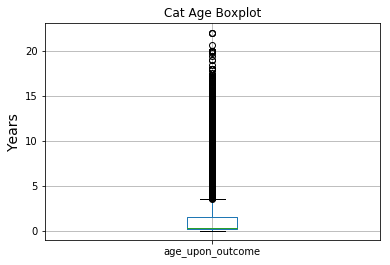

In [32]:
# cat age plot

catagepandas['age_upon_outcome'] = catagepandas['age_upon_outcome']/365
catagepandas.boxplot(column = ["age_upon_outcome"])
plt.ylabel("Years", fontsize = 14)
plt.title("Cat Age Boxplot")
plt.show()

Most cats have age lower than 4 years. There are many outliers in the plot.  

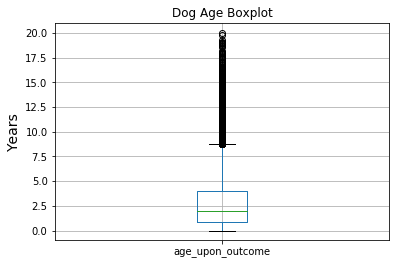

In [33]:
# dog age plot

dogagepandas['age_upon_outcome'] = dogagepandas['age_upon_outcome']/365
dogagepandas.boxplot(column = ["age_upon_outcome"])
plt.ylabel("Years", fontsize = 14)
plt.title("Dog Age Boxplot")
plt.show()

Most dogs have age lower than 8 years. There are many outliers in the plot.  

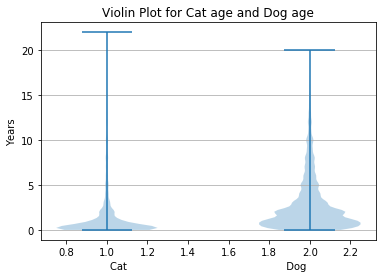

In [34]:
# cat age and dog age violin plot

fig, axes = plt.subplots()
axes.violinplot(dataset = [catagepandas['age_upon_outcome'].values, 
                           dogagepandas['age_upon_outcome'].values])

axes.set_title('Violin Plot for Cat age and Dog age')
axes.yaxis.grid(True)
axes.set_xlabel('Cat                                                   Dog')
axes.set_ylabel('Years')

plt.show()

We can see from the violin plot that the eldest cat is elder than the eldest dog. The age distribution of dog is more even that that of cats.  

### 3.2.2 Amount of acitivity records in Astin Animal Shelter by month

We want to see the line chart of amount of activities. 

In [35]:
# calculate number of animals coming by month

dog_cat_shelterdata_for_eda.select(date_format(dog_cat_shelterdata_for_eda['monthyear'],"yyyy-MM").alias('ts').cast("date"))
dog_cat_shelterdata_for_eda_timeSplit = dog_cat_shelterdata_for_eda.withColumn("Year_month", date_format(dog_cat_shelterdata_for_eda['monthyear'],"yyyy-MM"))
Year_month_count = dog_cat_shelterdata_for_eda_timeSplit.groupBy("Year_month").count().orderBy("Year_month")
Year_month_count = Year_month_count.where(Year_month_count['Year_month']<="2017-12")
Year_month_count.show(10)

+----------+-----+
|Year_month|count|
+----------+-----+
|   2013-10| 1528|
|   2013-11| 1257|
|   2013-12| 1428|
|   2014-01| 1201|
|   2014-02| 1023|
|   2014-03| 1222|
|   2014-04| 1251|
|   2014-05| 1480|
|   2014-06| 1596|
|   2014-07| 1965|
+----------+-----+
only showing top 10 rows



Here are top 10 months with most records:

In [36]:
Year_month_count.orderBy(desc("count")).show(10)

+----------+-----+
|Year_month|count|
+----------+-----+
|   2014-07| 1965|
|   2015-07| 1743|
|   2014-08| 1695|
|   2015-06| 1679|
|   2017-07| 1601|
|   2014-06| 1596|
|   2015-05| 1589|
|   2017-08| 1550|
|   2015-08| 1538|
|   2014-09| 1531|
+----------+-----+
only showing top 10 rows



We could see from the results that June, July and Augest are peak months for accomdodating new animals.

Text(0.5, 1.0, 'Amount of activities in Astin Animal Shelter')

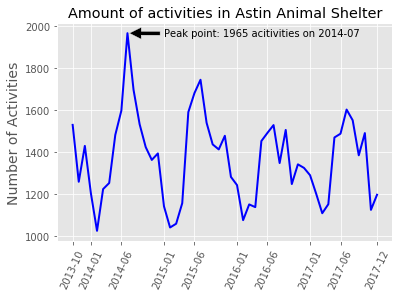

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig = plt.figure()
ax = fig.add_subplot(111)
Year_month_count_pd = Year_month_count.toPandas()
x=Year_month_count_pd.iloc[:,0]
y=Year_month_count_pd.iloc[:,1]

line, = ax.plot(x, y, color='b',lw=2)
ax.annotate('Peak point: 1965 acitivities on 2014-07', xy=('2014-07', 1965), xytext=("2015-01", 1950),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.xticks(rotation=65)
plt.xticks(['2013-10','2014-01','2014-06','2015-01','2015-06','2016-01','2016-06','2017-01','2017-06','2017-12'])
plt.ylabel("Number of Activities", fontsize = 14)
plt.title('Amount of activities in Astin Animal Shelter')

We can clearly see the seasonal pattern in the line chart, i.e. The amount of acitivties increases from the bottom, winter, to the top, summer. The peak point was 1965, happened in July 2014.   

### 3.2.3 Sex

We want to see the sex structure of animals sent to the shelter.

Text(0.5, 1.0, 'Sex information of cats')

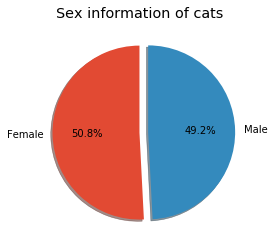

In [38]:
# summary of cat sex

cat_sex = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Cat").select(col("sex")).groupBy("sex").count()
cat_sex_pd = cat_sex.toPandas()
plt.pie(cat_sex_pd["count"],explode=(0,0.1), labels=["Female","Male"], autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Sex information of cats')

Text(0.5, 1.0, 'Sex information of dogs')

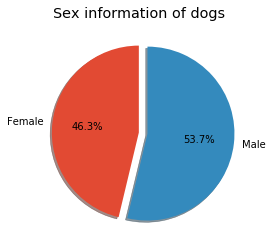

In [39]:
# summary of dog sex

dog_sex = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Dog").select(col("sex")).groupBy("sex").count()
dog_sex_pd = dog_sex.toPandas()
plt.pie(dog_sex_pd["count"],explode=(0,0.1), labels=["Female","Male"], autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Sex information of dogs')

We see female cats account for a slightly bigger part and so do male dogs. Overall, we do not find huge differnce in the number of female and male animals.

### 3.2.4 Color

We are given the exact data of animal colors, i.e. we know all colors that an animal has. The intuition here is to divide the animals into two groups, one with single color and the other with multiple colors, and do not make further classification for multiple color animals. Since multiple colors are separated by a slash, we count the number of slash of each cell and create a new column named "color_num". We could also use this column as a new variable in the prediction process.

Text(0.5, 1.0, 'Color information of cats')

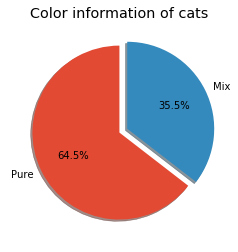

In [40]:
# summary of cat color

cat_color = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Cat").select(col("is_sc")).groupBy("is_sc").count()
cat_color_pd = cat_color.toPandas()
plt.pie(cat_color_pd["count"],explode=(0,0.1), labels=["Pure","Mix"], autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Color information of cats')

Text(0.5, 1.0, 'Color information of dogs')

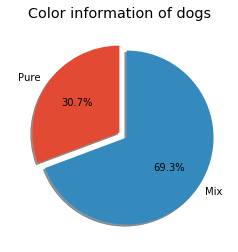

In [41]:
# summary of dog color

dog_color = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Dog").select(col("is_sc")).groupBy("is_sc").count()
dog_color_pd = dog_color.toPandas()
plt.pie(dog_color_pd["count"],explode=(0,0.1), labels=["Pure","Mix"], autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Color information of dogs')

We see that cats are mainly with one single color, and dogs are more likely to have multiple colors.

### 3.2.5 Fertility

We want to see how many animals are able to give babies and whether people like this feature or not.

Text(0.5, 1.0, 'Fertility information of cats')

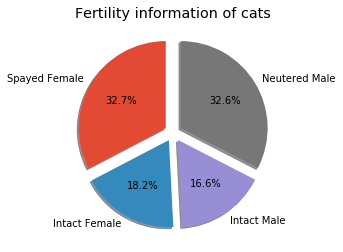

In [42]:
# summary of cat fertility

cat_fer = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Cat").select(col("reproduction"),col("sex")).groupBy("sex","reproduction").count()
cat_fer_pd = cat_fer.toPandas()
plt.pie(cat_fer_pd["count"],explode=(0.1,0.1,0.1,0.1), labels=["Spayed Female","Intact Female","Intact Male","Neutered Male"], autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Fertility information of cats')

Text(0.5, 1.0, 'Fertility information of dogs')

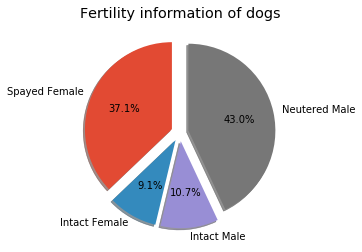

In [43]:
# summary of dog fertility

dog_fer = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Dog").select(col("reproduction"),col("sex")).groupBy("sex","reproduction").count()
dog_fer_pd = dog_fer.toPandas()
plt.pie(dog_fer_pd["count"],explode=(0.1,0.1,0.1,0.1), labels=["Spayed Female","Intact Female","Intact Male","Neutered Male"], autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Fertility information of dogs')

The result shows that most of the animals are unable to give babies no matter for male or female, dogs or cats. And this ratio is even higher for dogs.

### 3.2.6 Outcome

There're eight outcomes for animals: adoption, transfer, return to owner, euthanasia, died, rto-adopt, missing and disposal. We want to see the number of animals in each category.

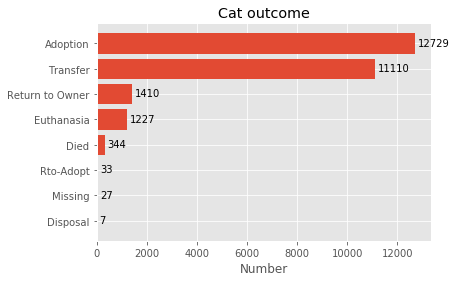

In [44]:
# summary of cat outcome type

cat_out = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Cat").select(col("outcome_type")).groupBy("outcome_type").count().orderBy("count")
cat_out_pd = cat_out.toPandas()

label = list(cat_out_pd["outcome_type"].values)
index = np.arange(len(label))
bars = plt.barh(index,cat_out_pd["count"],align="center")
plt.yticks(index, label, fontsize=10)
plt.xlabel('Number')
plt.title("Cat outcome")
for bar in bars:
    xval = bar.get_width()
    plt.text(xval+100, bar.get_y()+0.3, xval)
plt.show()

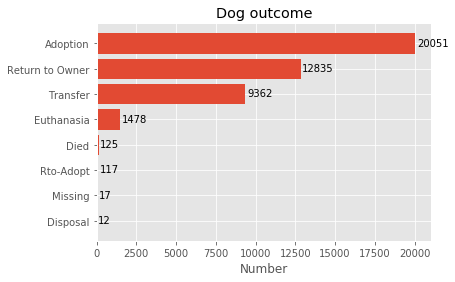

In [45]:
# summary of dog outcome type

dog_out = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Dog").select(col("outcome_type")).groupBy("outcome_type").count().orderBy("count")
dog_out_pd = dog_out.toPandas()

label = list(dog_out_pd["outcome_type"].values)
index = np.arange(len(label))
bars = plt.barh(index,dog_out_pd["count"],align="center")
plt.yticks(index, label, fontsize=10)
plt.xlabel('Number')
plt.title("Dog outcome")
for bar in bars:
    xval = bar.get_width()
    plt.text(xval+100, bar.get_y()+0.3, xval)
plt.show()

We see that most animals are adopted, many are returned to the owner which is good, some transfer to other places (maybe other shelters or hospitals), and the rest five outcomes account for a very small part. Our goal is to look into the features of those animals that got adopted.

### 3.2.7 Number of times an animal was sent to the shelter

It's interesting to know that one animal may be sent to the shelter many times, though this rarely happens. Some of them escaped from the new home and was resent to thier owner many times. A few of them were returned by thier onwer back to the shelter and are waiting for a new owner.

In [46]:
# number of times that an animal was sent to the shelter

cat_time = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Cat").select(col("animal_id")).groupBy("animal_id").count()
cat_time = cat_time.withColumn("resend",col("count")!=1)
cat_time_count = cat_time.select(col("count").alias("cat_send_num"))\
    .groupBy("cat_send_num")\
    .count()\
    .orderBy(desc("cat_send_num"))

dog_time = dog_cat_shelterdata_for_eda.where(col("animal_type")=="Dog").select(col("animal_id")).groupBy("animal_id").count()
dog_time = dog_time.withColumn("resend",col("count")!=1)
dog_time_count = dog_time.select(col("count").alias("dog_send_num"))\
    .groupBy("dog_send_num")\
    .count()\
    .orderBy(desc("dog_send_num"))

In [47]:
cat_time_count.show()
dog_time_count.show()

+------------+-----+
|cat_send_num|count|
+------------+-----+
|           5|    1|
|           4|    3|
|           3|   96|
|           2|  998|
|           1|24586|
+------------+-----+

+------------+-----+
|dog_send_num|count|
+------------+-----+
|          11|    2|
|          10|    1|
|           8|    3|
|           7|    6|
|           6|   23|
|           5|   61|
|           4|  181|
|           3|  716|
|           2| 3744|
|           1|33096|
+------------+-----+



Most of the animals only have one record and some of them are resent to the shelter a couple of times. The most naughty dog got lost 10 times after being adopted by an owner!

# 4. Featuring engineering

## 4.1 Data preprocessing for feature transformation

We now want to split the dataframe into two individual parts, one for dogs and one for cats, each containing six variables: age, color, sex, fertility, quarter and if_weekday. Later we may take breed and name information into account, and even take animal type as an independent variable. To do this, we need to delete unuseful columns, convert useful ones into binary varialbes, and convert the timestamp to two separate columns: month and day.

In [116]:
# split the dataframe and keep the columns we're going to make use of

df_dog = dog_cat_shelterdata.where(col("animal_type")=="Dog")
df_cat = dog_cat_shelterdata.where(col("animal_type")=="Cat")

df_dog = df_dog.select("age_upon_outcome", "is_sc", "sex", "reproduction", "monthyear", "outcome_type")
df_cat = df_cat.select("age_upon_outcome", "is_sc", "sex", "reproduction", "monthyear", "outcome_type")

In [117]:
# convert column "outcome_type" to a binary variable (i.e. adopted or not)

df_dog = df_dog.withColumn("outcome_type", (df_dog["outcome_type"]=="Adoption").cast("int"))
df_cat = df_cat.withColumn("outcome_type", (df_cat["outcome_type"]=="Adoption").cast("int"))

In [118]:
# split column "monthyear" into month and day, and convert to "quarter" & is_wkd"

df_dog = df_dog.withColumn("monthyear", to_date("monthyear","yyyy-MM-dd'T'HH:mm:ss"))
df_dog = df_dog.withColumn("month", month("monthyear"))
df_dog = df_dog.withColumn("day", dayofweek("monthyear"))
df_dog = df_dog.withColumn("is_wkd", when(df_dog["day"]>5, 0).otherwise(1)).drop(df_dog["day"])

df_cat = df_cat.withColumn("monthyear", to_date("monthyear","yyyy-MM-dd'T'HH:mm:ss"))
df_cat = df_cat.withColumn("month", month("monthyear"))
df_cat = df_cat.withColumn("day", dayofweek("monthyear"))
df_cat = df_cat.withColumn("is_wkd", when(df_cat["day"]>5, 0).otherwise(1)).drop(df_cat["day"])

cond = """case when month > 9 then 'Q4'
            else case when month > 6 then 'Q3'
                else case when month > 3 then 'Q2'
                    else case when month > 0 then 'Q1'
                        end
                    end
                end
            end as quarter"""

df_dog = df_dog.withColumn("quarter", expr(cond))
df_cat = df_cat.withColumn("quarter", expr(cond))

In [119]:
# convert age in days into years

from pyspark.sql.functions import round
df_dog = df_dog.withColumn("age", round(df_dog["age_upon_outcome"]/365,1))
df_cat = df_cat.withColumn("age", round(df_cat["age_upon_outcome"]/365,1))

In [120]:
# convert column "reproduction" into binary variable

df_dog = df_dog.withColumn("reproduction", when(df_dog["reproduction"]=="Intact", 1).otherwise(0))
df_cat = df_cat.withColumn("reproduction", when(df_cat["reproduction"]=="Intact", 1).otherwise(0))

In [121]:
# keep only useful columns

df_dog_reg = df_dog.select("age", "is_sc", "sex", "reproduction", "quarter", "is_wkd", "outcome_type")
df_cat_reg = df_cat.select("age", "is_sc", "sex", "reproduction", "quarter", "is_wkd", "outcome_type")

In [122]:
# check the first several rows

df_dog_reg.show(5)
df_cat_reg.show(5)

+---+-----+------+------------+-------+------+------------+
|age|is_sc|   sex|reproduction|quarter|is_wkd|outcome_type|
+---+-----+------+------------+-------+------+------------+
|1.0|    0|Female|           0|     Q4|     1|           0|
|1.2|    0|  Male|           0|     Q2|     1|           1|
|9.0|    1|  Male|           0|     Q2|     1|           0|
|0.3|    0|  Male|           1|     Q4|     1|           0|
|3.0|    1|Female|           0|     Q4|     1|           0|
+---+-----+------+------------+-------+------+------------+
only showing top 5 rows

+---+-----+------+------------+-------+------+------------+
|age|is_sc|   sex|reproduction|quarter|is_wkd|outcome_type|
+---+-----+------+------------+-------+------+------------+
|0.0|    1|  Male|           1|     Q3|     1|           0|
|0.2|    0|Female|           1|     Q3|     1|           1|
|0.3|    0|Female|           0|     Q2|     1|           1|
|1.0|    0|Female|           0|     Q1|     0|           0|
|0.1|    0|  Ma

## 4.2 Feature transformation

Now we have all six features in a clean dataframe: age, sex, reproduction, is_singleColor, quarter, is_weekday. We want then to test the correlation among these variables. Since our data contains text, we use RFormula to transform these features all into figures.

In [123]:
# construct an RFormula

from pyspark.ml.feature import RFormula
reg = RFormula(formula="outcome_type ~ .")

In [124]:
# fit and transform

dog_reg_result = reg.fit(df_dog_reg).transform(df_dog_reg)
dog_reg_result.show(5, False)

+---+-----+------+------------+-------+------+------------+---------------------------------+-----+
|age|is_sc|sex   |reproduction|quarter|is_wkd|outcome_type|features                         |label|
+---+-----+------+------------+-------+------+------------+---------------------------------+-----+
|1.0|0    |Female|0           |Q4     |1     |0           |(8,[0,4,7],[1.0,1.0,1.0])        |0.0  |
|1.2|0    |Male  |0           |Q2     |1     |1           |(8,[0,2,6,7],[1.2,1.0,1.0,1.0])  |1.0  |
|9.0|1    |Male  |0           |Q2     |1     |0           |[9.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0]|0.0  |
|0.3|0    |Male  |1           |Q4     |1     |0           |[0.3,0.0,1.0,1.0,1.0,0.0,0.0,1.0]|0.0  |
|3.0|1    |Female|0           |Q4     |1     |0           |(8,[0,1,4,7],[3.0,1.0,1.0,1.0])  |0.0  |
+---+-----+------+------------+-------+------+------------+---------------------------------+-----+
only showing top 5 rows



In [125]:
cat_reg_result = reg.fit(df_cat_reg).transform(df_cat_reg)
cat_reg_result.show(5, False)

+---+-----+------+------------+-------+------+------------+---------------------------------+-----+
|age|is_sc|sex   |reproduction|quarter|is_wkd|outcome_type|features                         |label|
+---+-----+------+------------+-------+------+------------+---------------------------------+-----+
|0.0|1    |Male  |1           |Q3     |1     |0           |(8,[1,3,4,7],[1.0,1.0,1.0,1.0])  |0.0  |
|0.2|0    |Female|1           |Q3     |1     |1           |[0.2,0.0,1.0,1.0,1.0,0.0,0.0,1.0]|1.0  |
|0.3|0    |Female|0           |Q2     |1     |1           |(8,[0,2,6,7],[0.3,1.0,1.0,1.0])  |1.0  |
|1.0|0    |Female|0           |Q1     |0     |0           |(8,[0,2],[1.0,1.0])              |0.0  |
|0.1|0    |Male  |1           |Q1     |1     |0           |(8,[0,3,7],[0.1,1.0,1.0])        |0.0  |
+---+-----+------+------------+-------+------+------------+---------------------------------+-----+
only showing top 5 rows



## 4.3 Correlation examination

Now that we have the feature vector, we could look into pairwise correlation and visualize the corr matrix.

In [126]:
dog_transformed_feature = dog_reg_result.select("features")
dog_transformed_feature_pd = dog_transformed_feature.toPandas()

dog_feature_mat = dog_transformed_feature_pd['features'].apply(lambda x : np.array(x.toArray())).as_matrix().reshape(-1,1)
dog_feature_arr = np.apply_along_axis(lambda x : x[0], 1, dog_feature_mat)

labels1 = ["age", "color", "sex", "reproduction", "Q4", "Q1", "Q2", "weekday"]
dog_feature_pd = pd.DataFrame(dog_feature_arr, columns=labels1)
dog_feature_pd.head()

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


age  color  sex  reproduction   Q4   Q1   Q2  weekday
0  1.0    0.0  0.0           0.0  1.0  0.0  0.0      1.0
1  1.2    0.0  1.0           0.0  0.0  0.0  1.0      1.0
2  9.0    1.0  1.0           0.0  0.0  0.0  1.0      1.0
3  0.3    0.0  1.0           1.0  1.0  0.0  0.0      1.0
4  3.0    1.0  0.0           0.0  1.0  0.0  0.0      1.0

In [127]:
cat_transformed_feature = cat_reg_result.select("features")
cat_transformed_feature_pd = cat_transformed_feature.toPandas()

cat_feature_mat = cat_transformed_feature_pd['features'].apply(lambda x : np.array(x.toArray())).as_matrix().reshape(-1,1)
cat_feature_arr = np.apply_along_axis(lambda x : x[0], 1, cat_feature_mat)

labels2 = ["age", "color", "sex", "reproduction", "Q3", "Q4", "Q2", "weekday"]
cat_feature_pd = pd.DataFrame(cat_feature_arr, columns=labels2)
cat_feature_pd.head()

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


age  color  sex  reproduction   Q3   Q4   Q2  weekday
0  0.0    1.0  0.0           1.0  1.0  0.0  0.0      1.0
1  0.2    0.0  1.0           1.0  1.0  0.0  0.0      1.0
2  0.3    0.0  1.0           0.0  0.0  0.0  1.0      1.0
3  1.0    0.0  1.0           0.0  0.0  0.0  0.0      0.0
4  0.1    0.0  0.0           1.0  0.0  0.0  0.0      1.0

In [128]:
!pip install seaborn
import seaborn as sns

pyspark 2.3.2 has requirement py4j==0.10.7, but you'll have py4j 0.10.8.1 which is incompatible.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [129]:
dog_feature_corr_mat = dog_feature_pd.corr().round(2)
cat_feature_corr_mat = cat_feature_pd.corr().round(2)

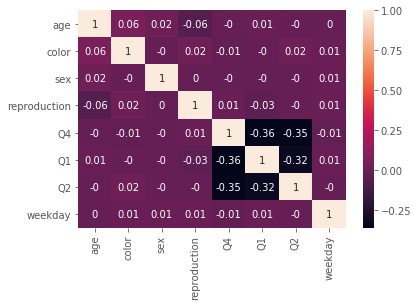

In [130]:
sns.heatmap(dog_feature_corr_mat, annot=True)

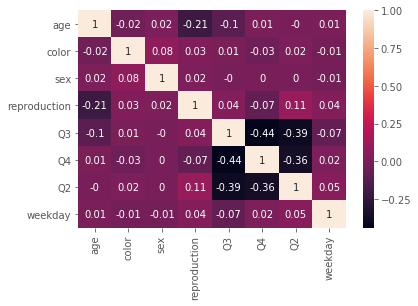

In [131]:
sns.heatmap(cat_feature_corr_mat, annot=True)